# Prepare Brown to Analyse with PCA

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : 2023/01/06
- update : 2023/01/06

https://github.com/JospehCeh/PhotoZ_PhD

## Import

In [1]:
import os,sys,re
from astropy.io import fits
from astropy.table import Table

In [2]:
# Import some generally useful packages

import os
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline
import pandas as pd
from itertools import cycle, islice

from scipy import interpolate

/Users/dagoret/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
from scipy import ndimage

#from scipy import interp as scinterp
from scipy.interpolate import interp1d

import glob
import collections
#from def_raw_seds import *

In [4]:
# to enlarge the sizes
params = {'legend.fontsize': 'large',
          'figure.figsize': (8, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

In [5]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [6]:
from def_raw_seds import *

In [7]:
from raw_data_analysis import *

In [8]:
#from spectroscopy import *

In [9]:
# Import the primary photometry classes from rubin_sim.photUtils

import rubin_sim.photUtils.Bandpass as Bandpass
import rubin_sim.photUtils.Sed as Sed
from rubin_sim.data import get_data_dir

In [10]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
# pysynphot
import pysynphot as S
S.refs.setref(area=1)
S.refs.getref()

{'graphtable': '/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/14l1632sm_tmg.fits',
 'comptable': '/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/16n1832tm_tmc.fits',
 'thermtable': '/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/tae17277m_tmt.fits',
 'area': 1,
 'waveset': 'Min: 500, Max: 26000, Num: 10000, Delta: None, Log: True'}

In [11]:
def ExtractSpectra(the_path):
    """
    input : path where all spectra are
    return list of spectra in pysynphot format
    """
    
    all_spectra = []
    all_filenames = os.listdir(the_path)
    all_fits_filenames = []
    
    for fn in all_filenames:
        if re.search(".*[.]fits",fn):
            all_fits_filenames.append(fn)
            
    all_fits_filenames = sorted(all_fits_filenames)
    
    for idx,fn in enumerate(all_fits_filenames):
        fullfilename = os.path.join(the_path,fn)
        spec = S.FileSpectrum(fullfilename)
        
        wav = spec.wave
        fl =  spec.flux
        gal_name =os.path.basename(spec.name).split('.')[0]
        
        #if np.isnan(wav).any() or np.isnan(fl).any():
        #    continue
        if idx==46:
            msg=f"Skip {idx} for Bruzual-Charlot : {gal_name}"
            print(msg)
            continue
        
        
        all_spectra.append(spec)
        
    return all_spectra


## Configuration

In [12]:
the_path = os.path.join(os.environ['PYSYN_CDBS'], 'grid', 'bc95','templates')

In [13]:
all_seds = ExtractSpectra(the_path)

Skip 46 for Bruzual-Charlot : bc95_d_50E8


In [14]:
NSED=len(all_seds)
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NSED)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NSED), alpha=1)

In [15]:
WL = np.arange(20000)

## Start

In [16]:
all_normspectra = []
all_integ = []
all_wl = []
all_name = []
all_sed = []
all_numbers = []

for idx,the_sed in enumerate(all_seds):
    
    wav = the_sed.wave
    fl =  the_sed.flux
    flunits = the_sed.fluxunits
    
    good = np.where(np.isfinite(fl))
    
    
    gal_name =os.path.basename(the_sed.name).split('.')[0]
    f = interpolate.interp1d(wav[good], fl[good],bounds_error=False,fill_value=0)

  
    # select wavelength in an appropriate range 
    wl=WL
    fl= f(WL)
    
    
    wlrange = np.where(np.logical_and(wl>=0,wl<=10000))[0]
    
    wl=wl[wlrange] 
    flambda=fl[wlrange]
    
    integ = np.trapz(flambda,wl)
    all_wl.append(wl)
    all_normspectra.append(flambda/integ)
    all_name.append(gal_name)
    all_numbers.append(idx)

In [17]:
df = pd.DataFrame()
df["index"] = all_numbers
df["name"]=all_name

In [18]:
df

,index,name
0,0,bc95_a_10E5
1,1,bc95_a_10E6
2,2,bc95_a_10E7
3,3,bc95_a_10E8
4,4,bc95_a_10E9
...,...,...
78,78,bc95_g_50E5
79,79,bc95_g_50E6
80,80,bc95_g_50E7
81,81,bc95_g_50E8


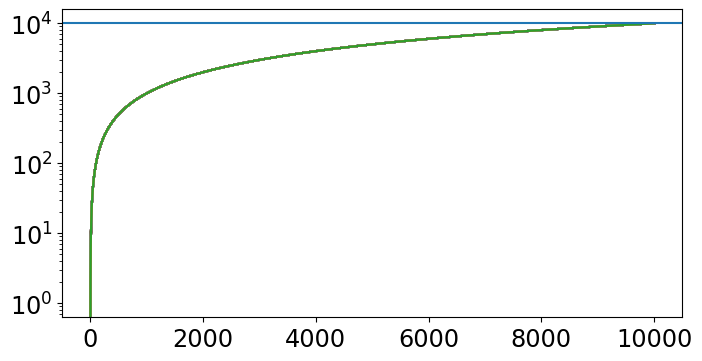

In [19]:
for idx in range(NSED):
    plt.plot(all_wl[idx])
#plt.axhline(20000)
plt.axhline(10000)
plt.yscale("log")

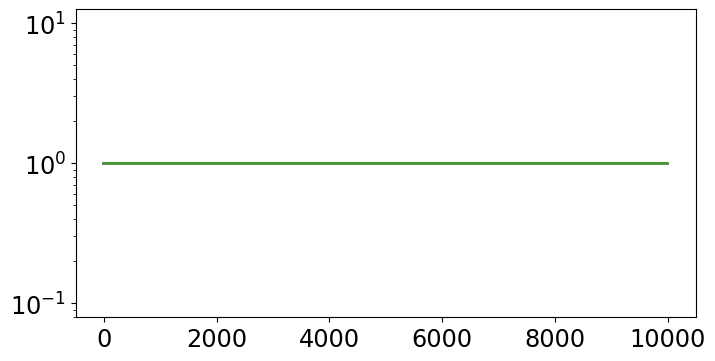

In [20]:
for idx in range(NSED):
    plt.plot(np.diff(all_wl[idx]))
plt.yscale("log")

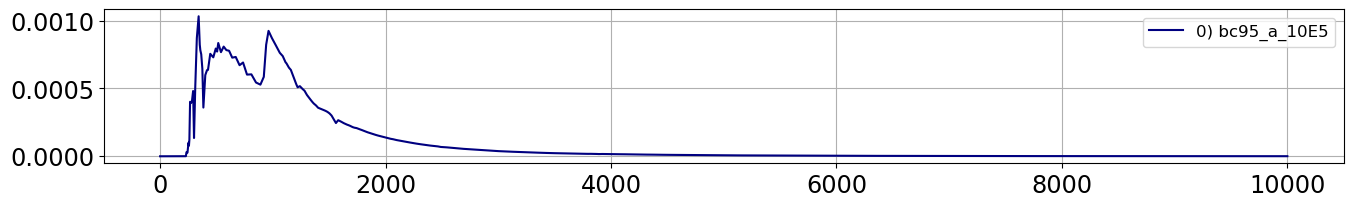

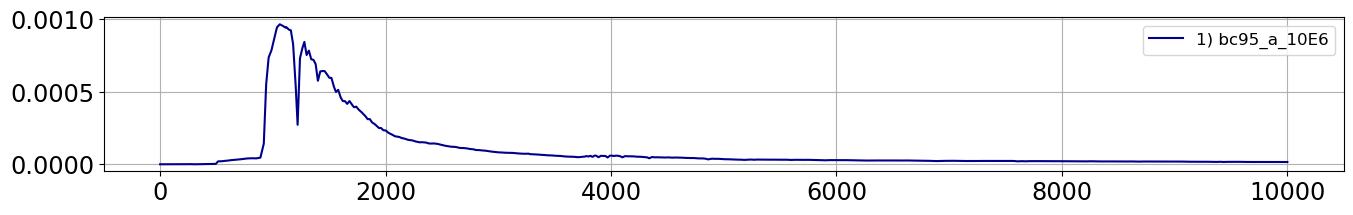

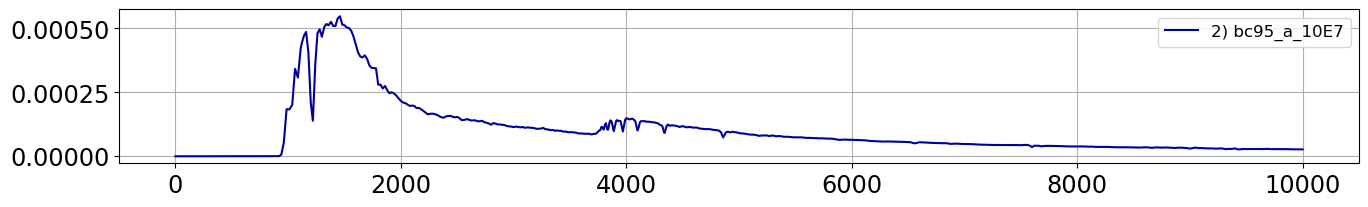

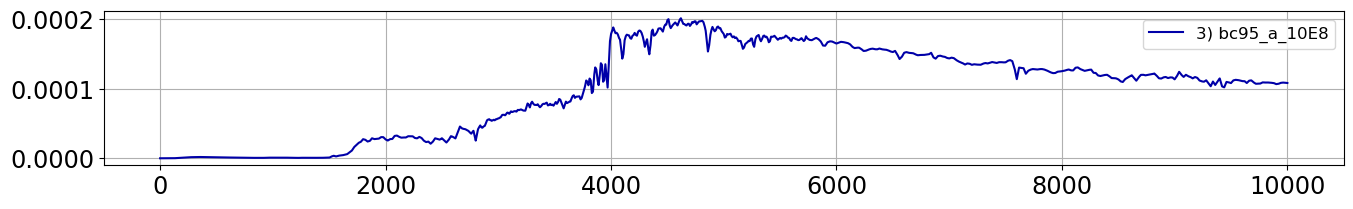

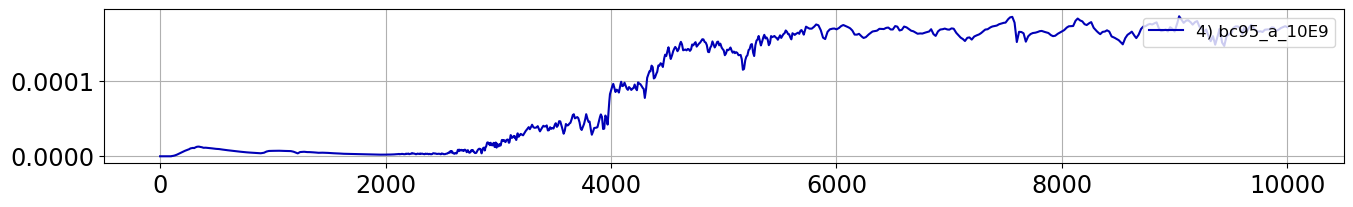

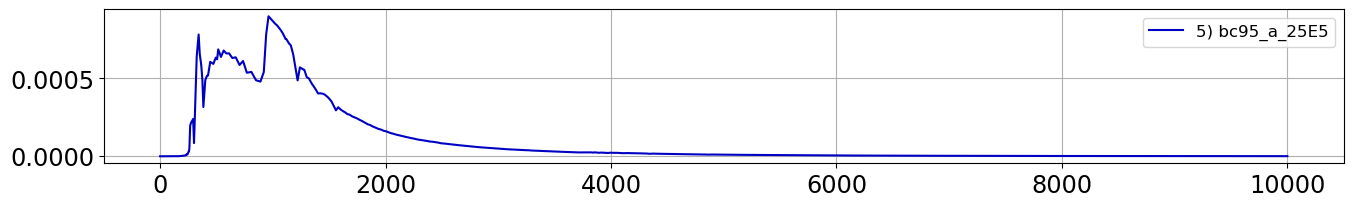

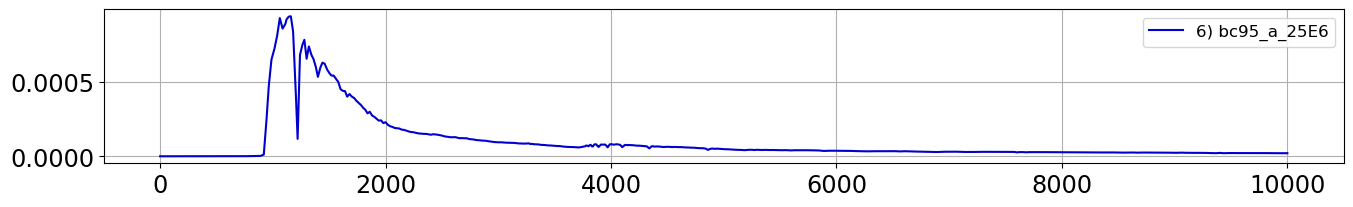

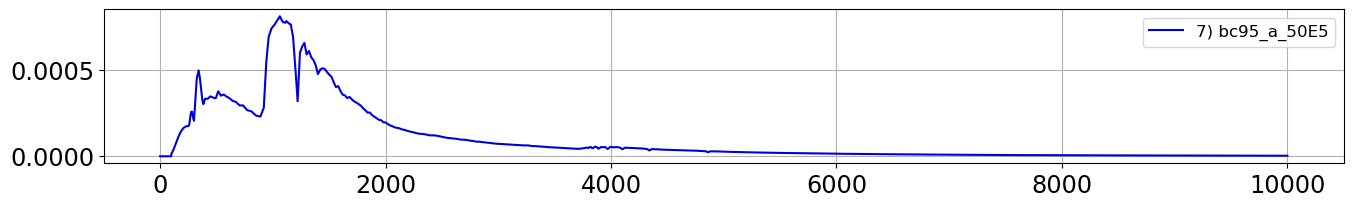

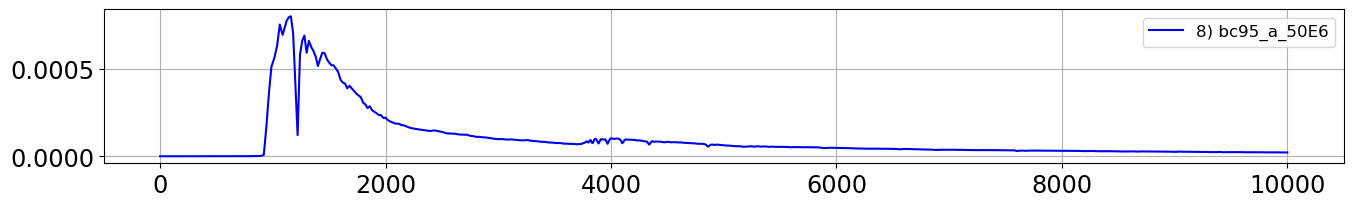

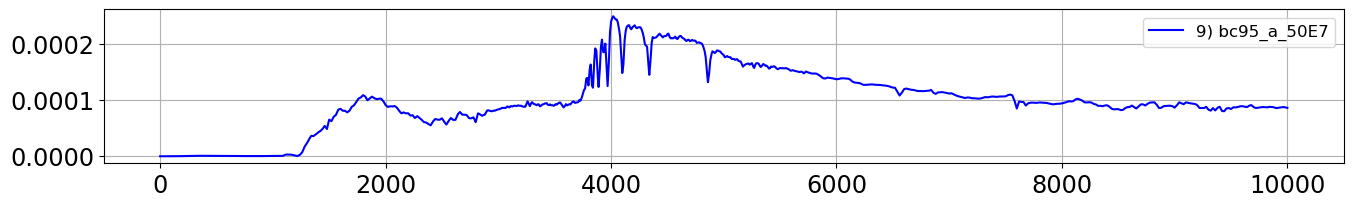

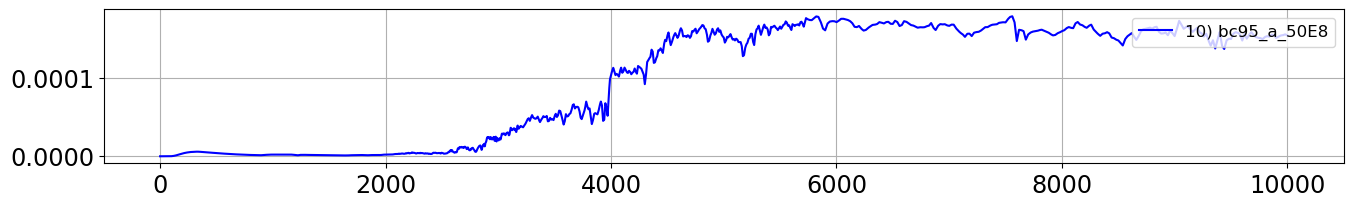

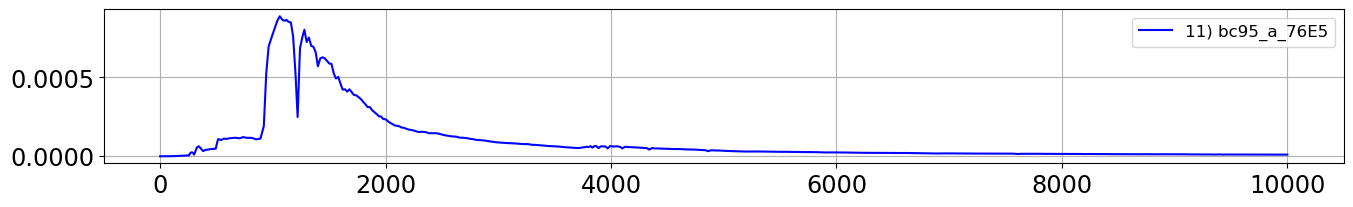

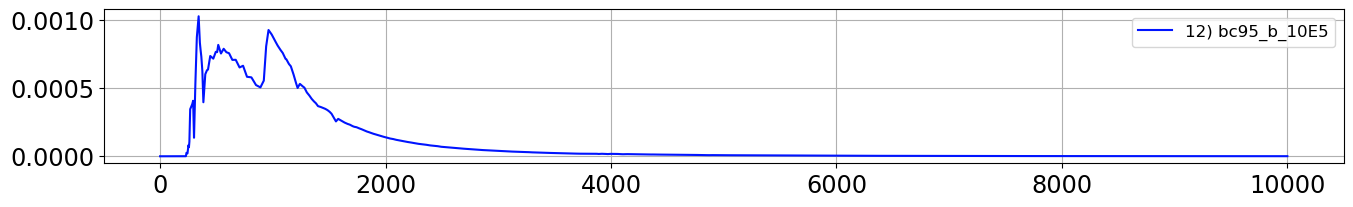

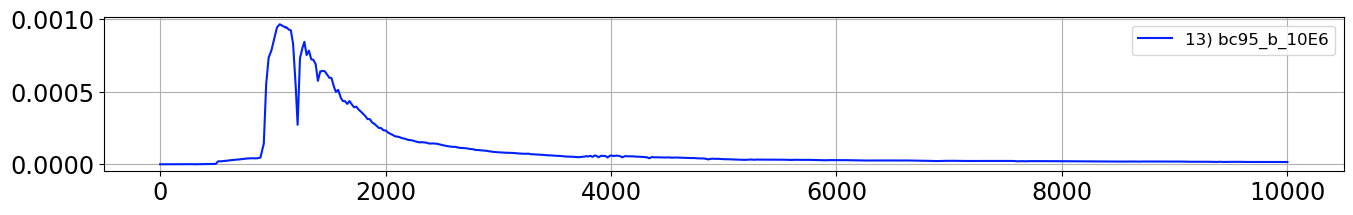

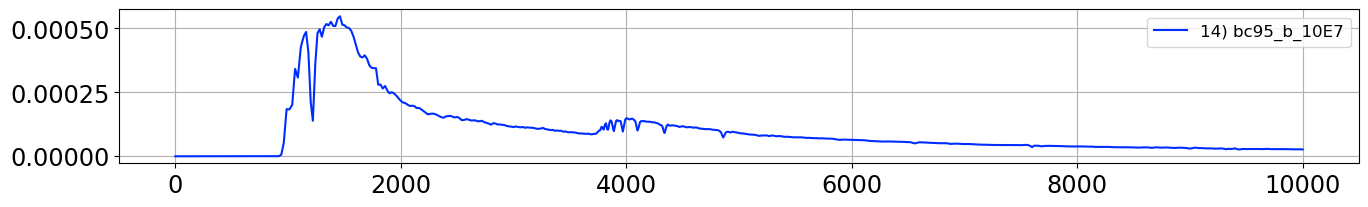

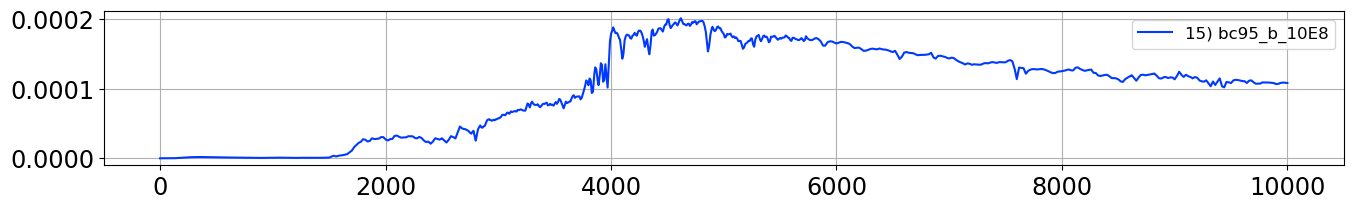

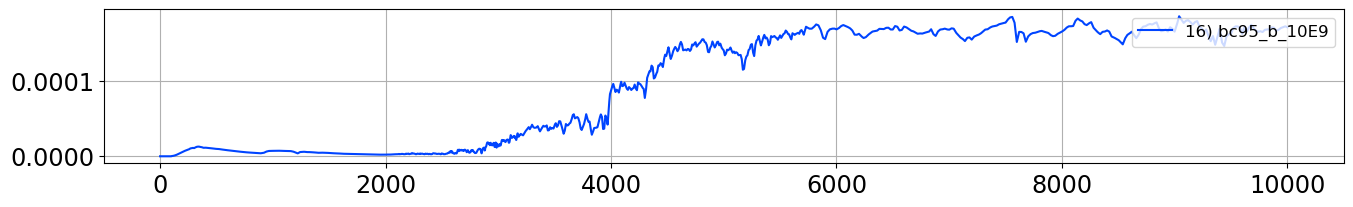

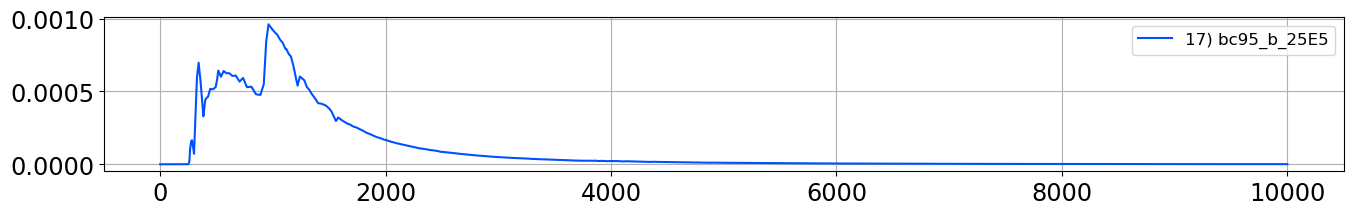

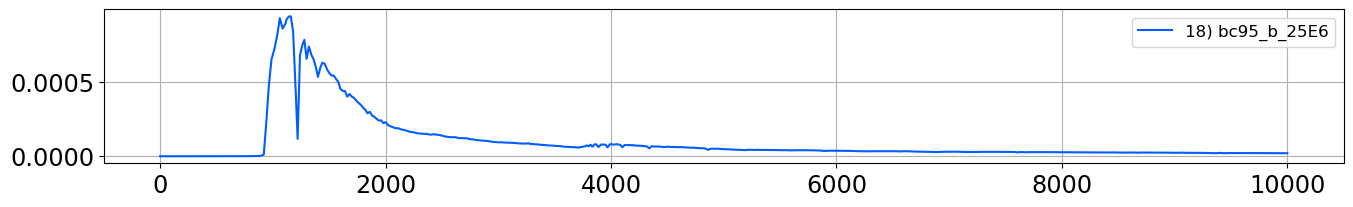

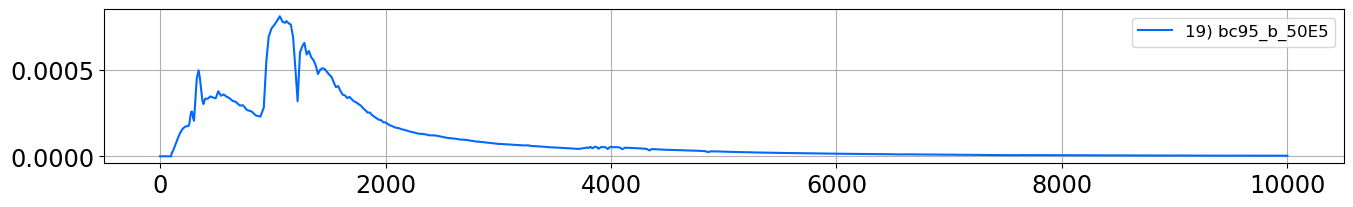

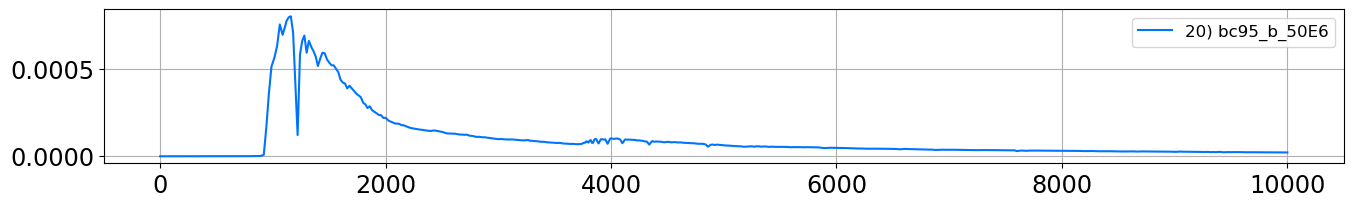

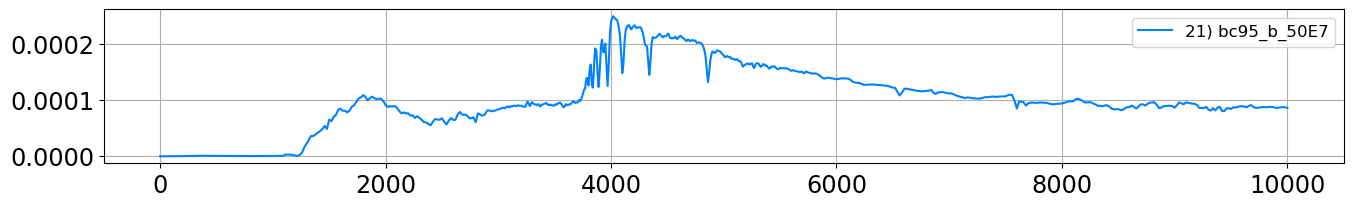

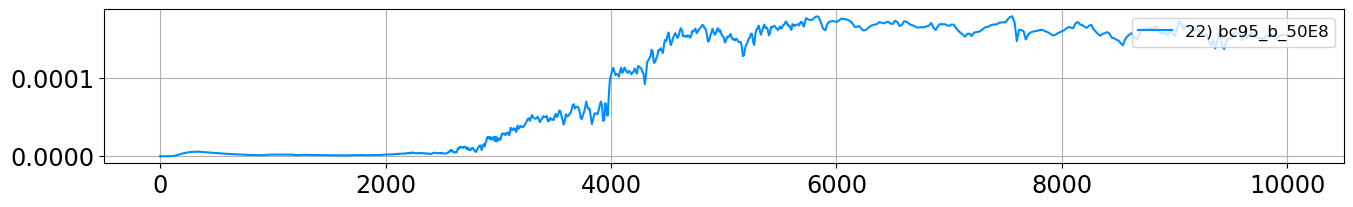

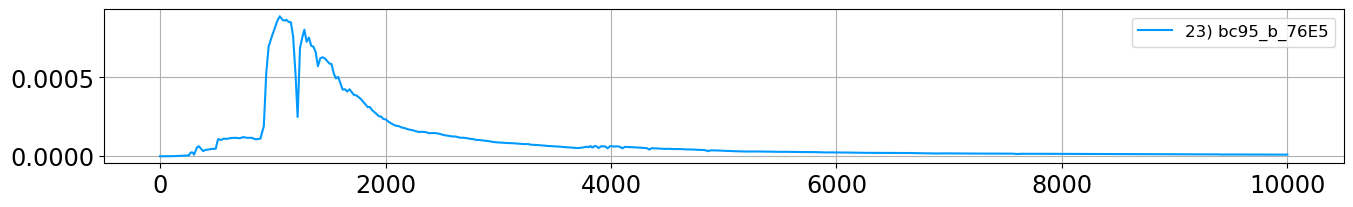

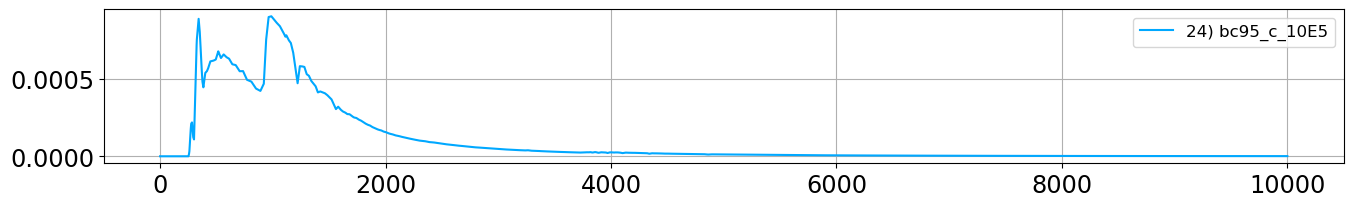

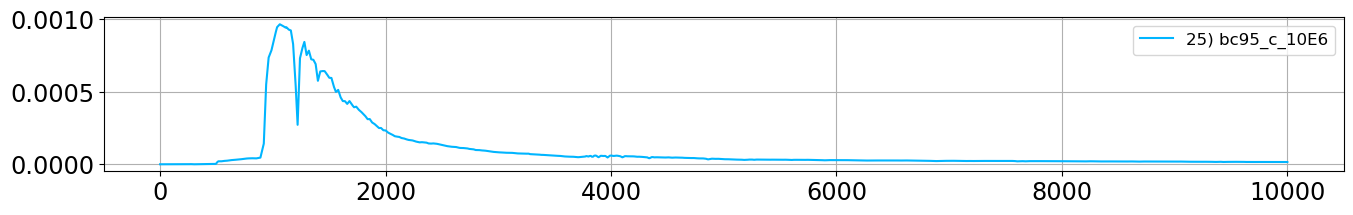

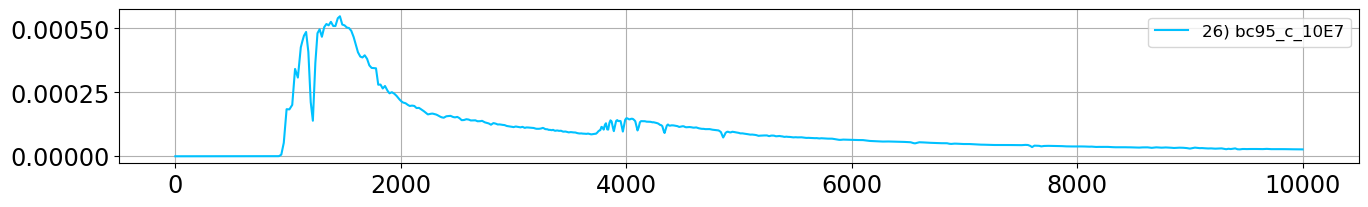

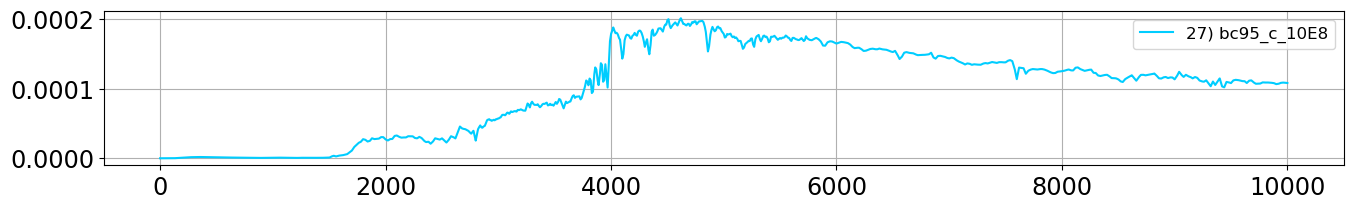

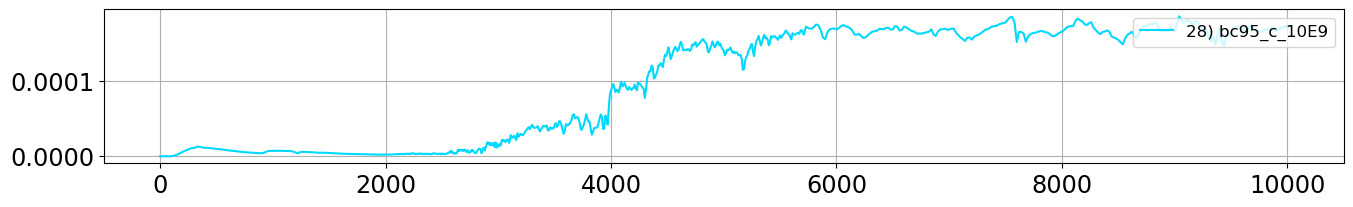

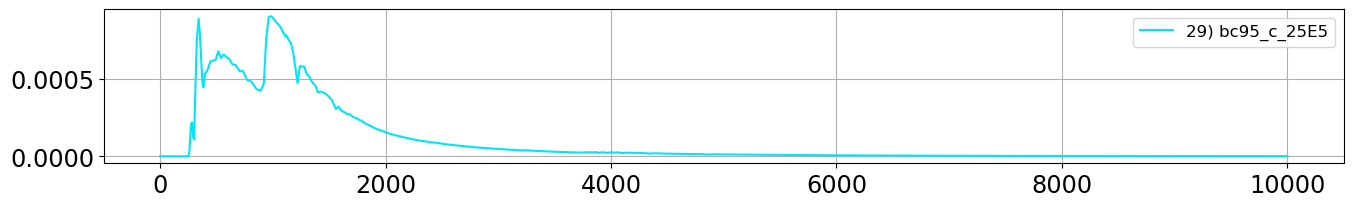

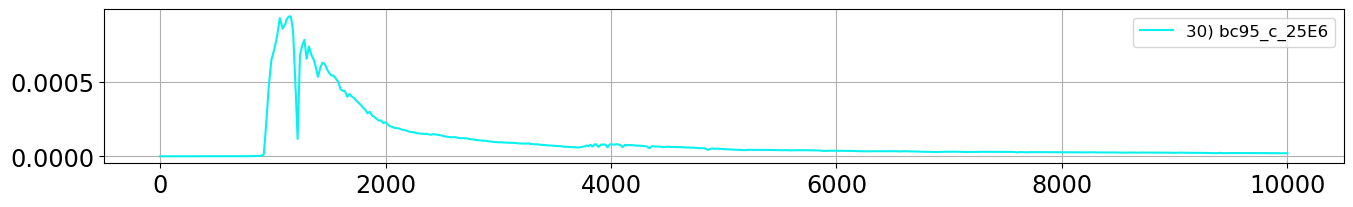

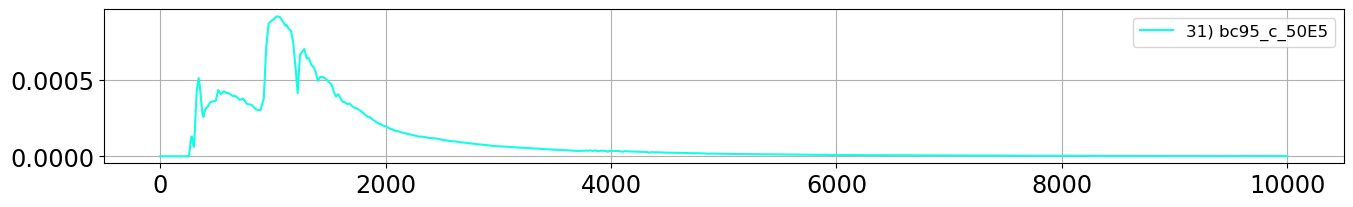

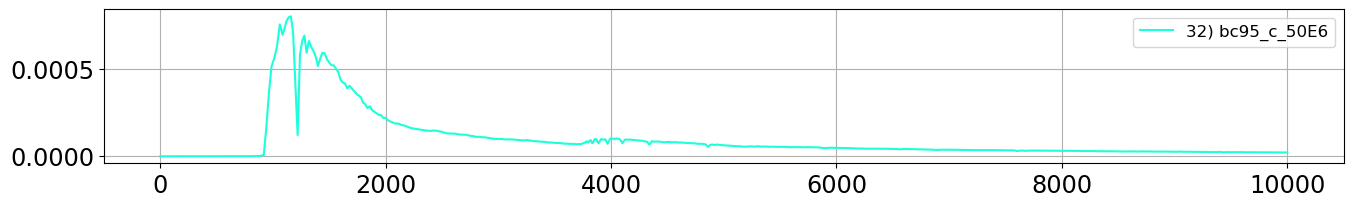

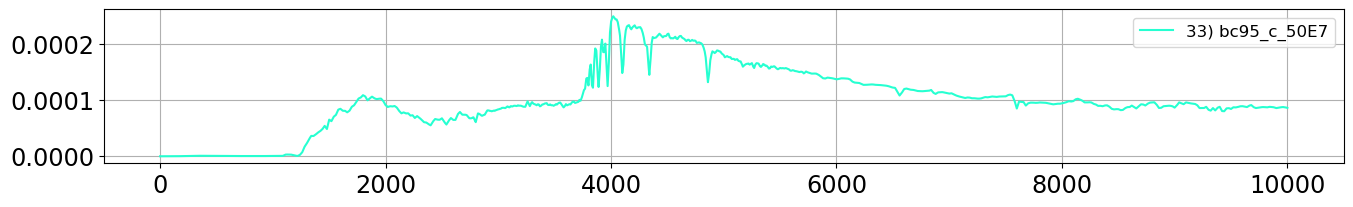

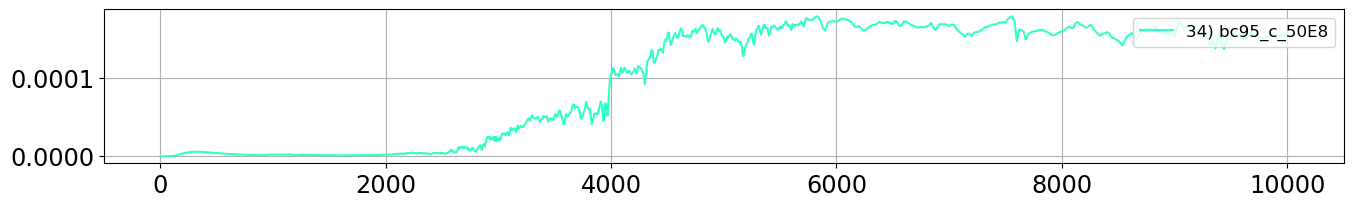

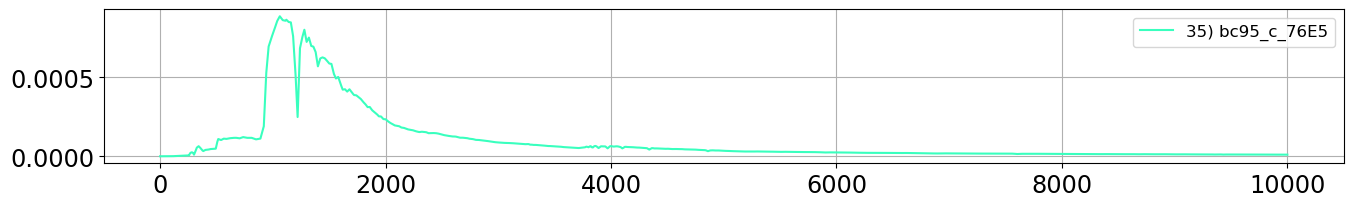

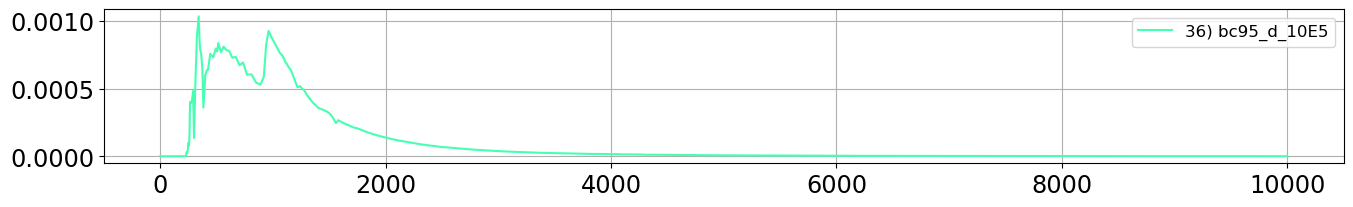

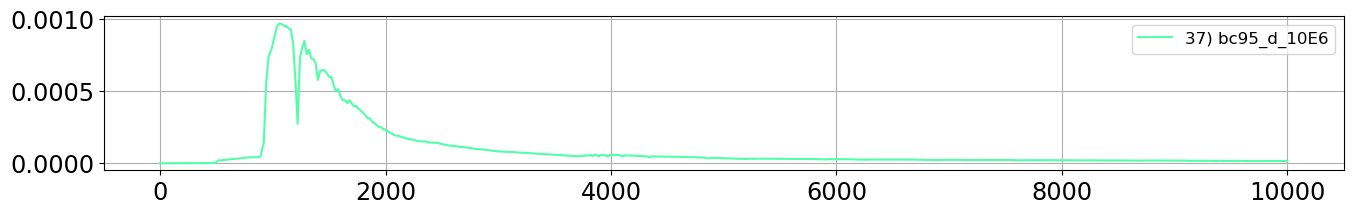

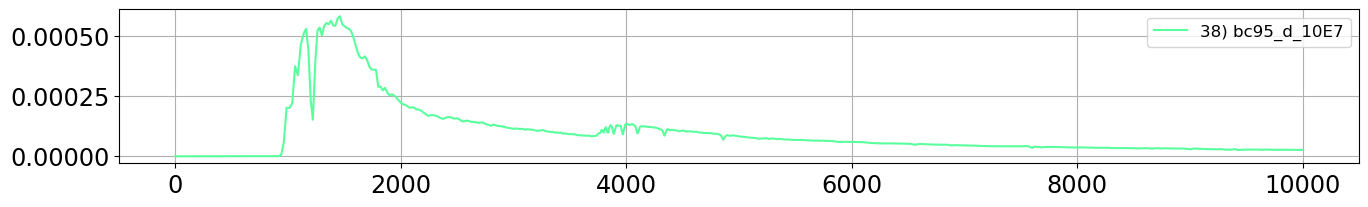

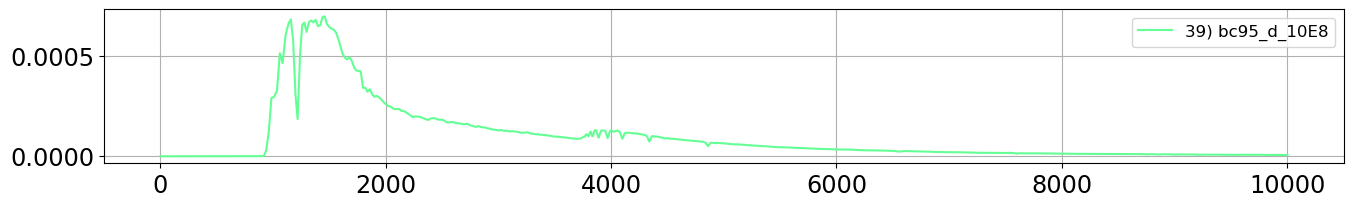

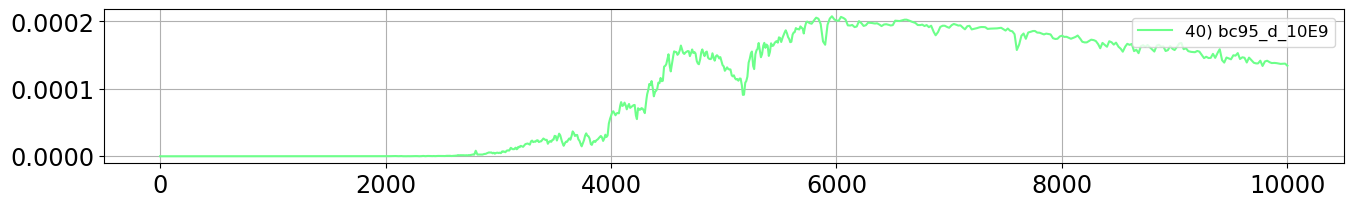

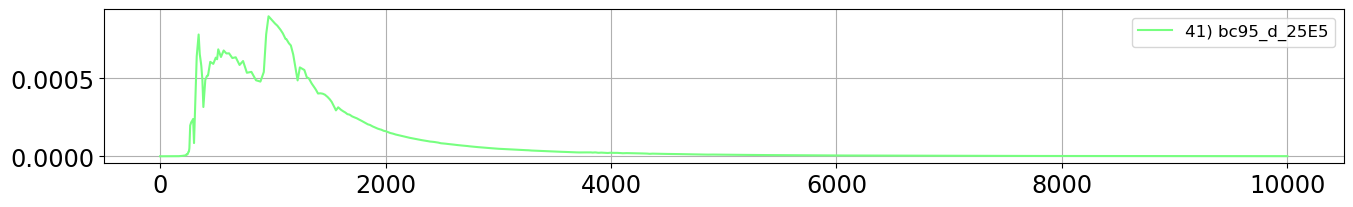

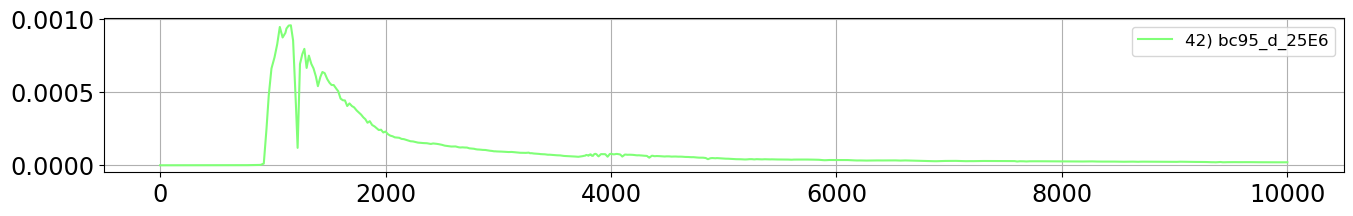

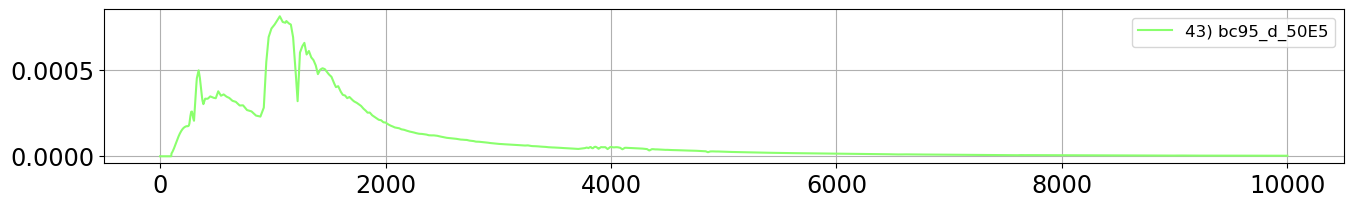

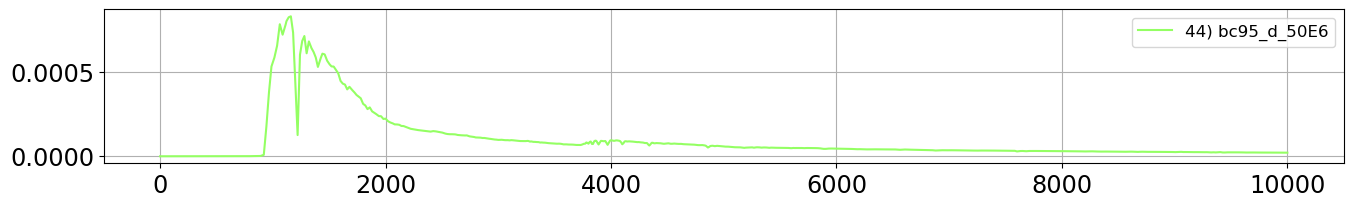

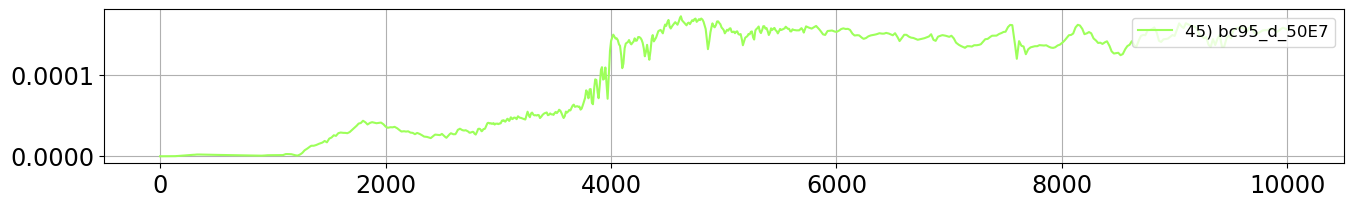

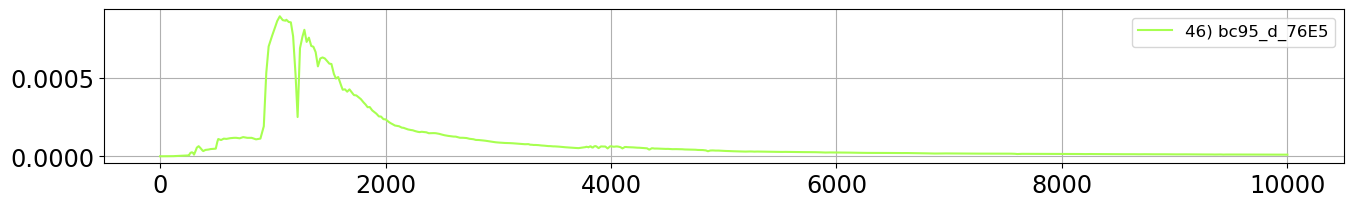

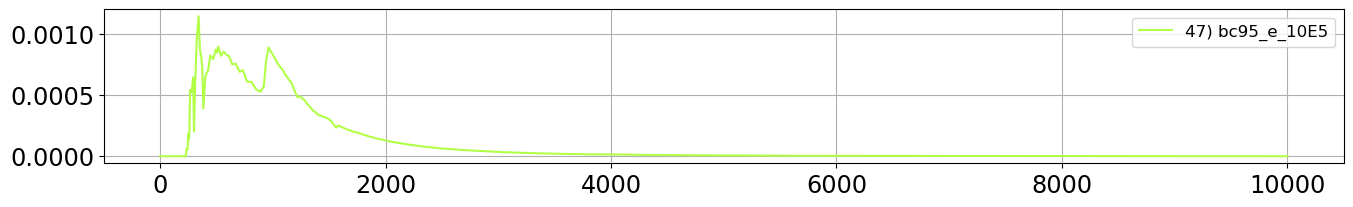

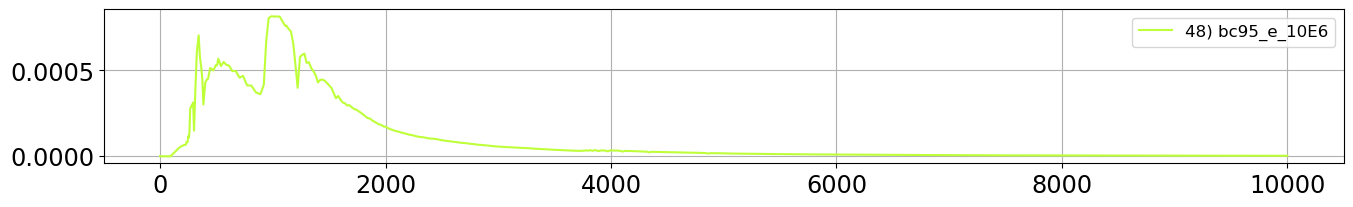

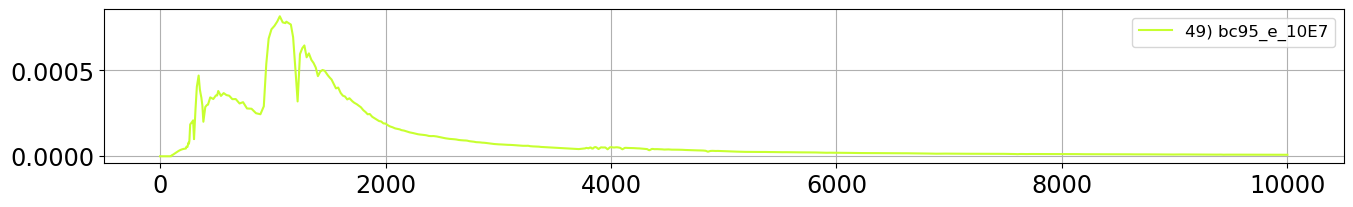

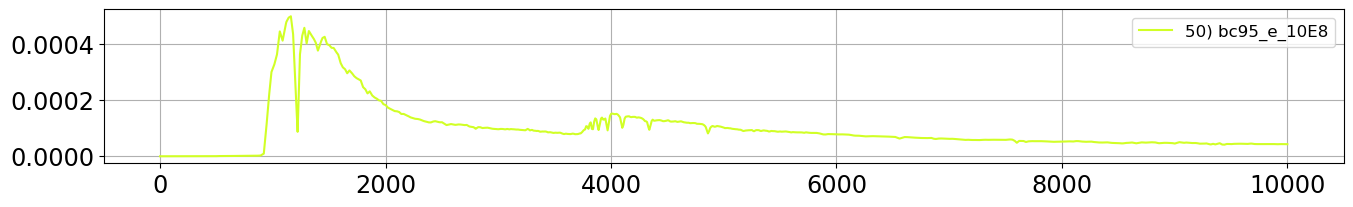

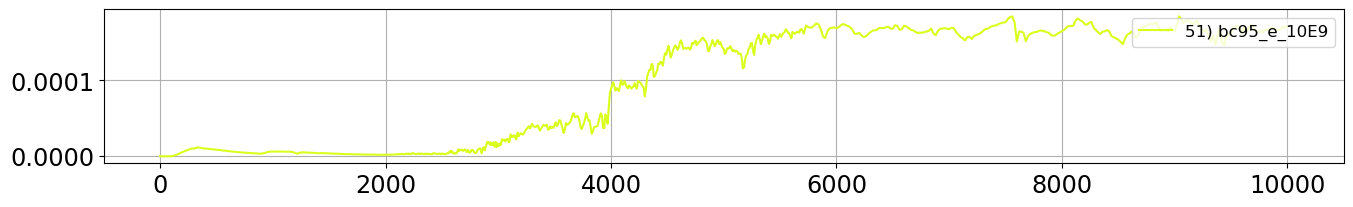

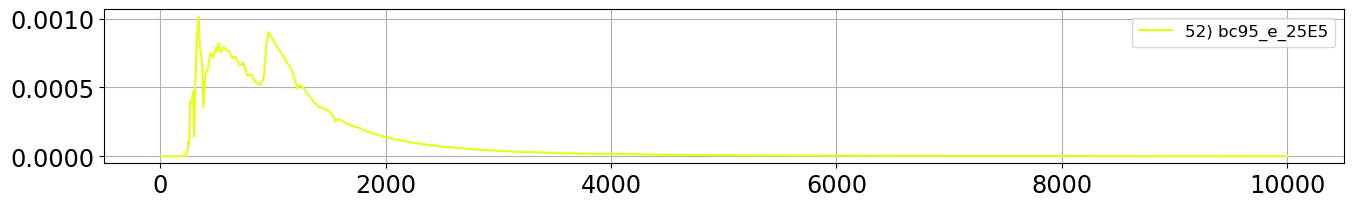

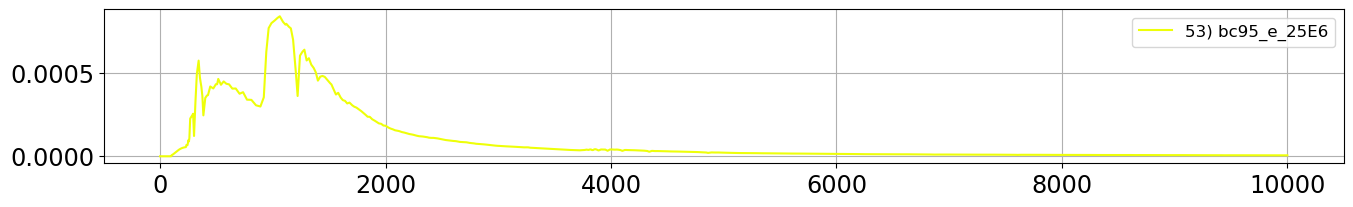

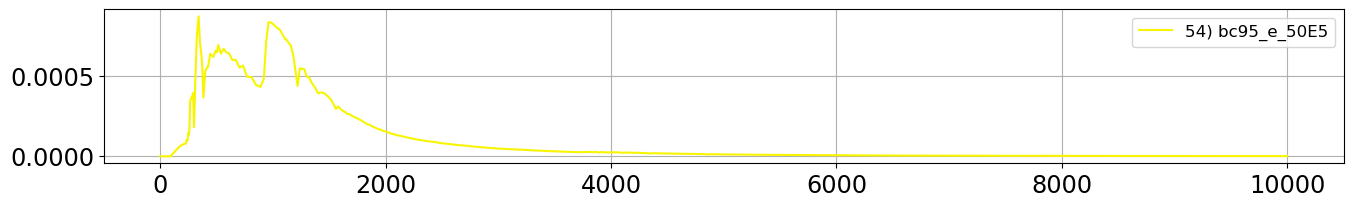

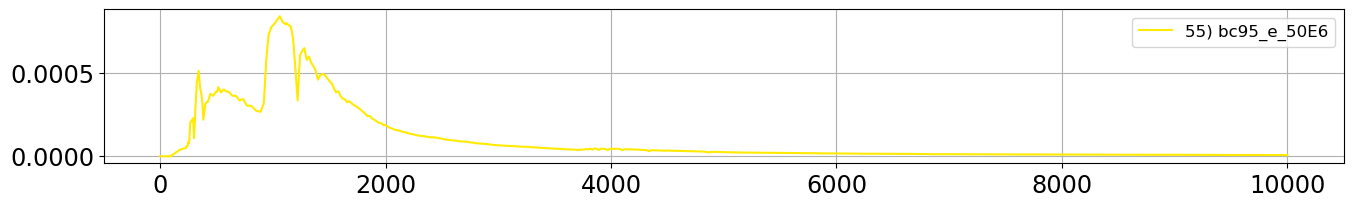

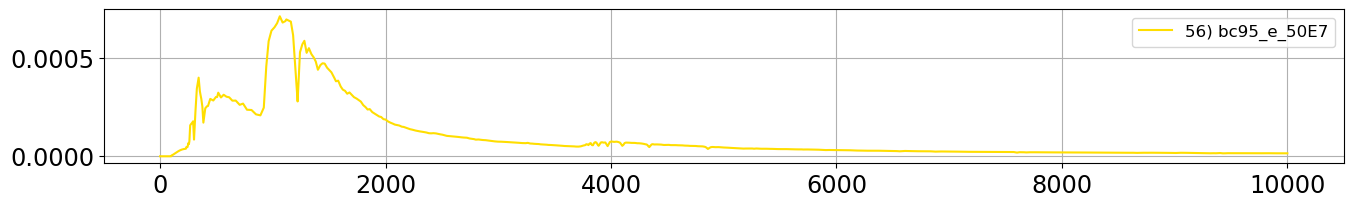

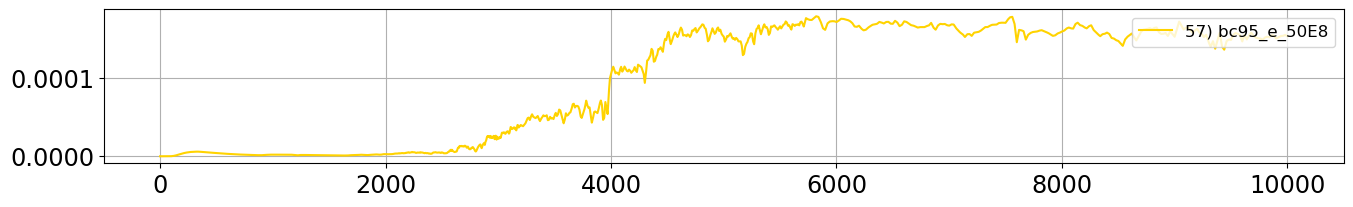

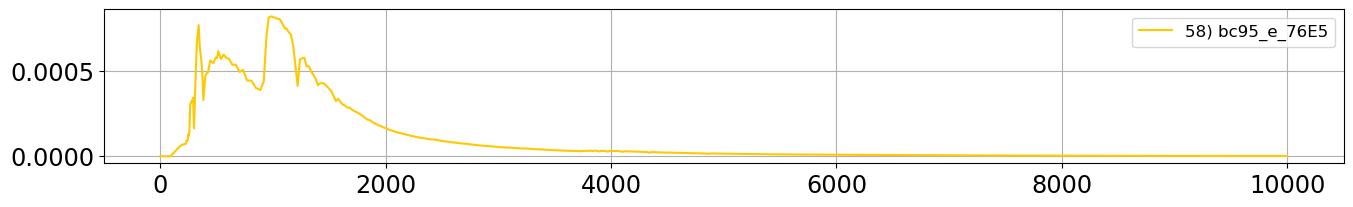

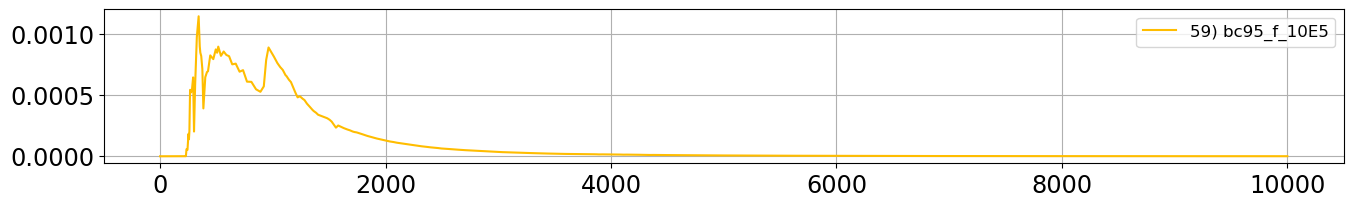

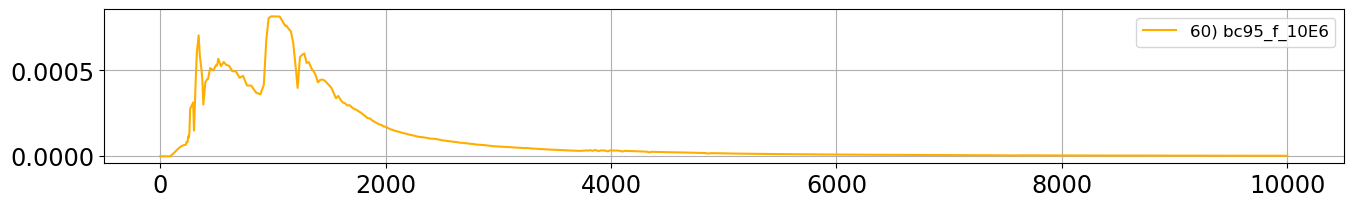

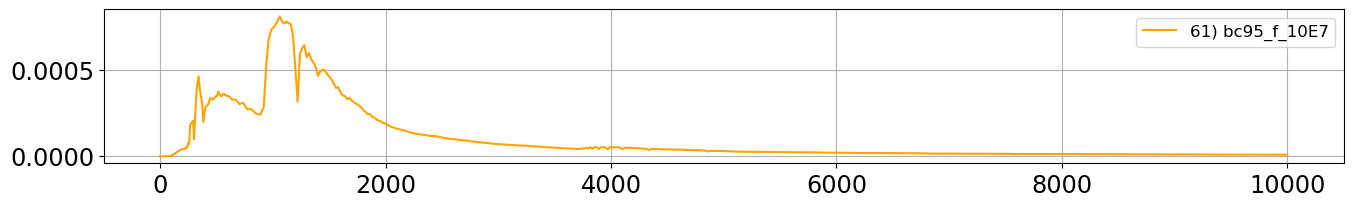

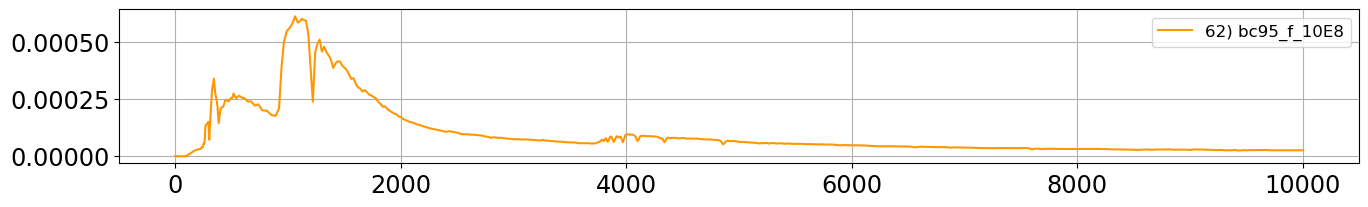

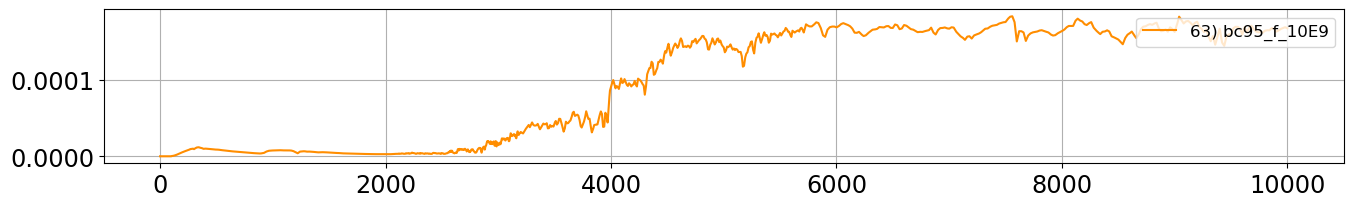

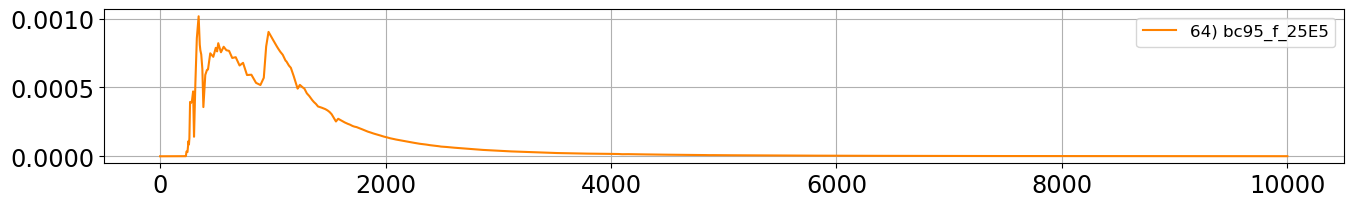

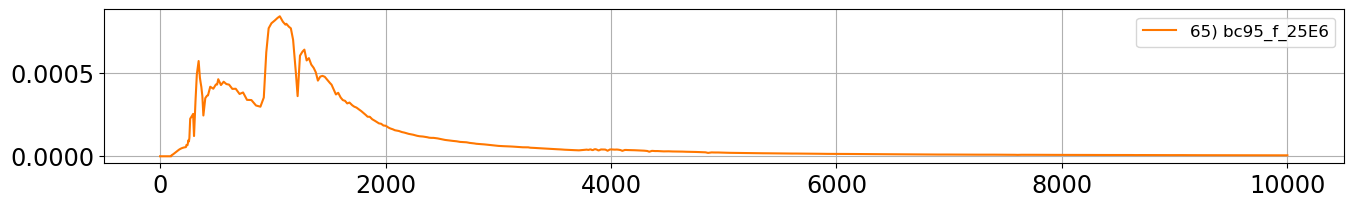

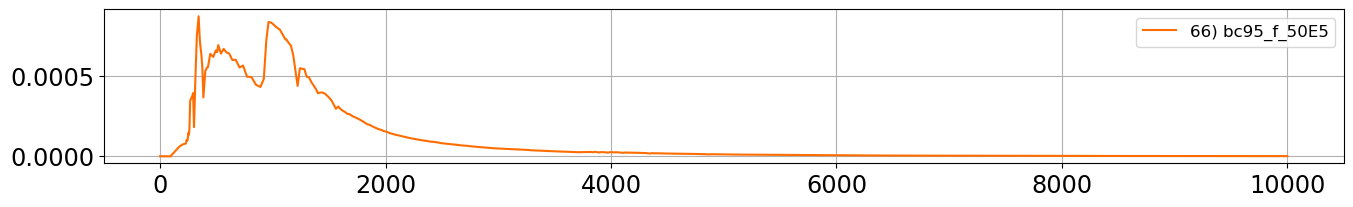

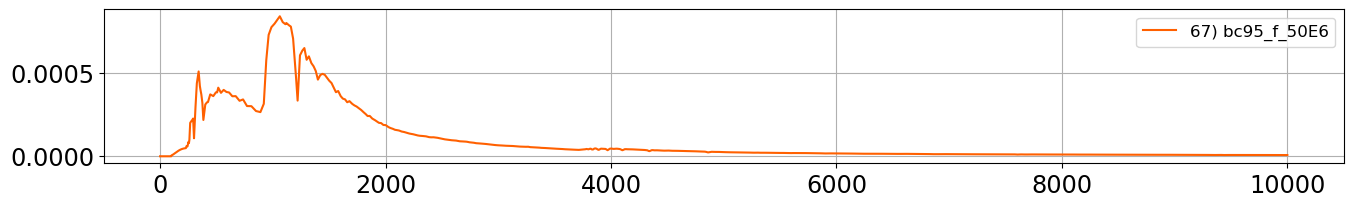

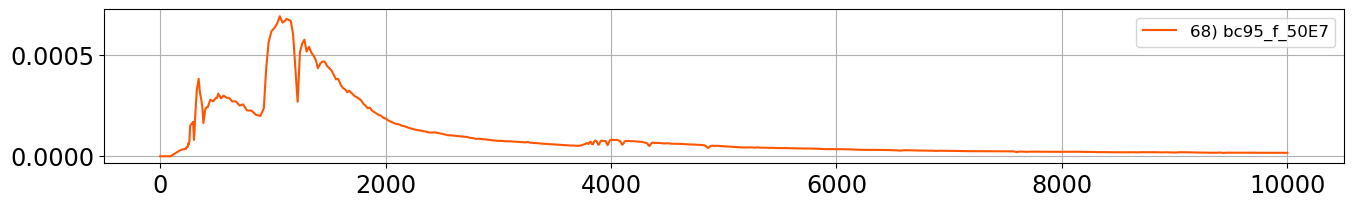

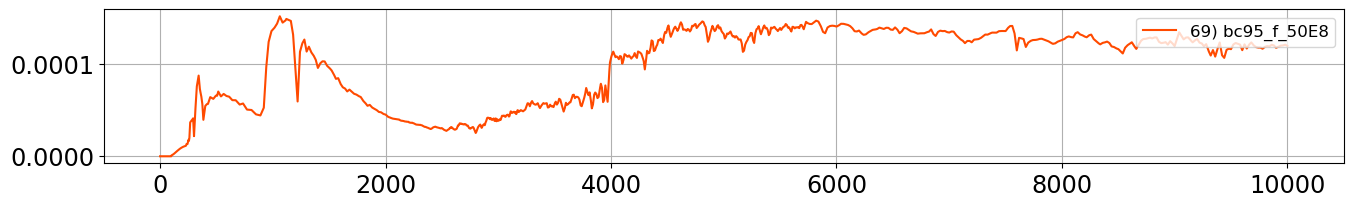

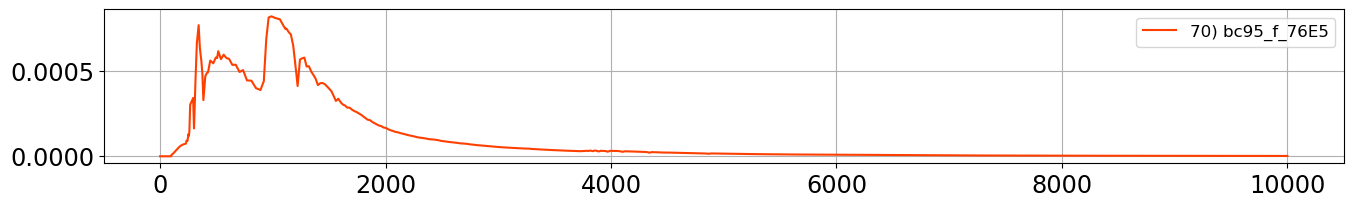

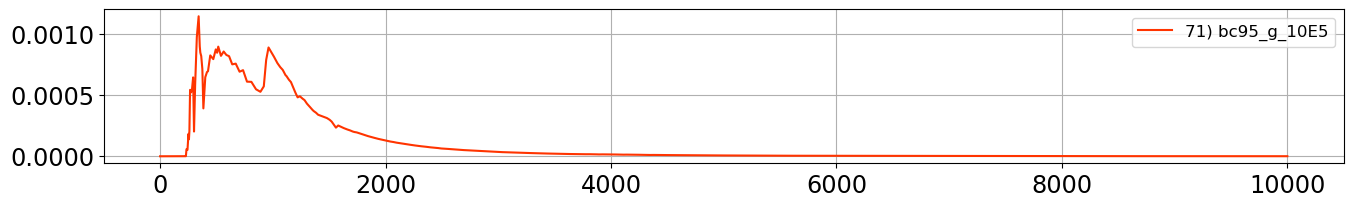

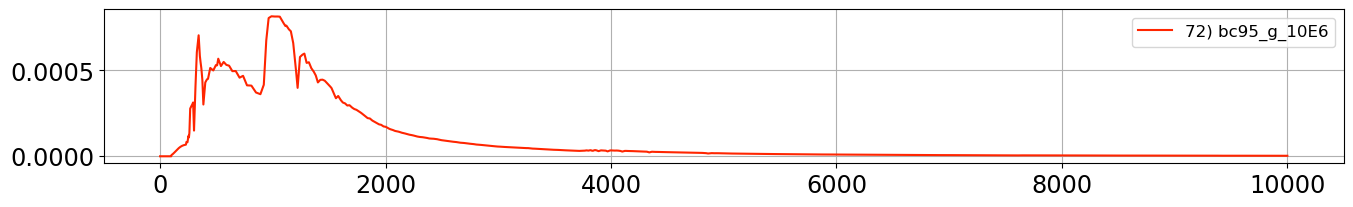

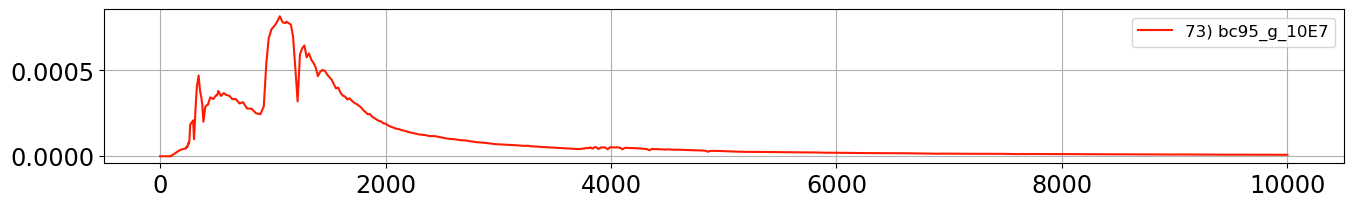

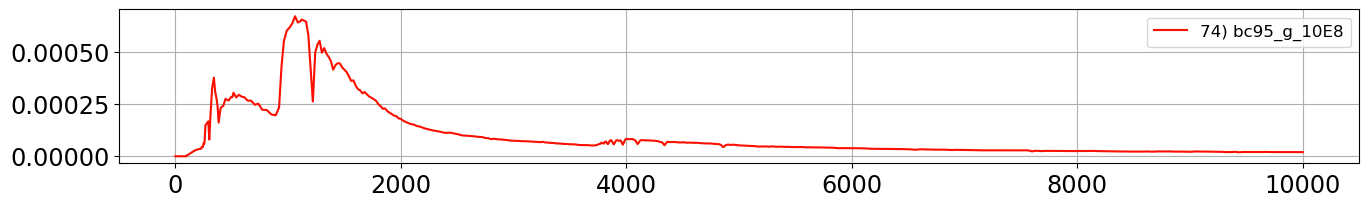

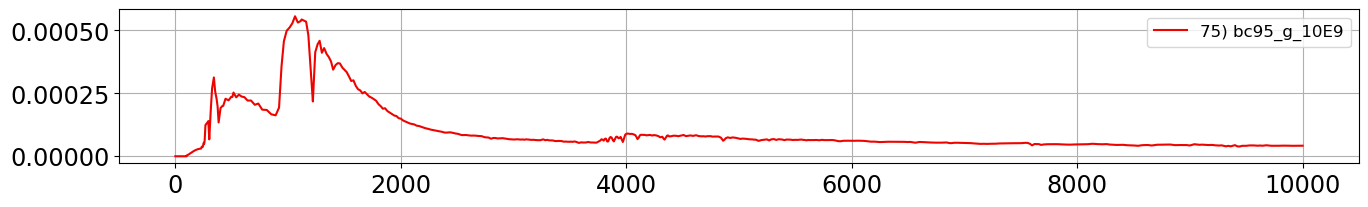

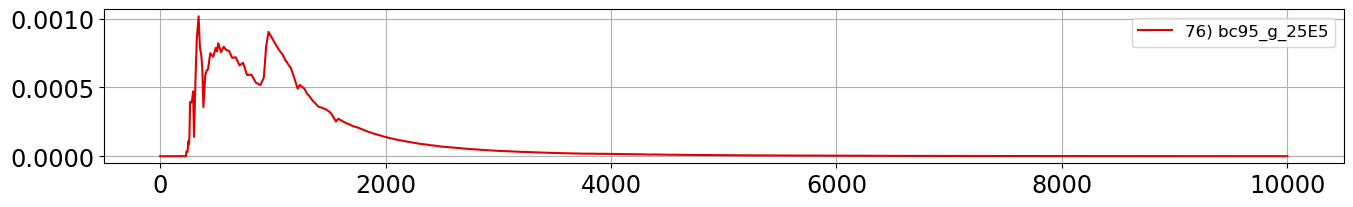

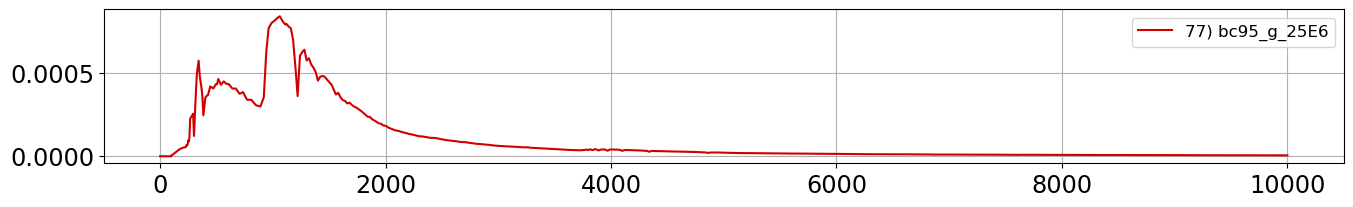

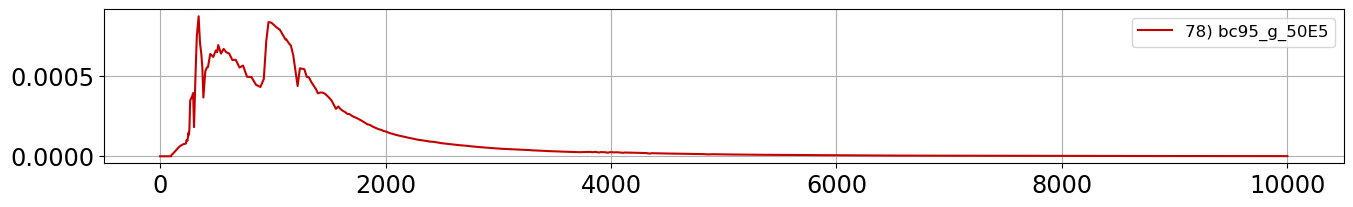

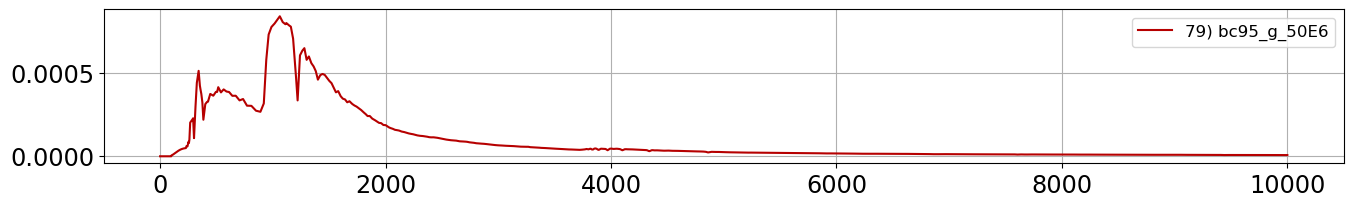

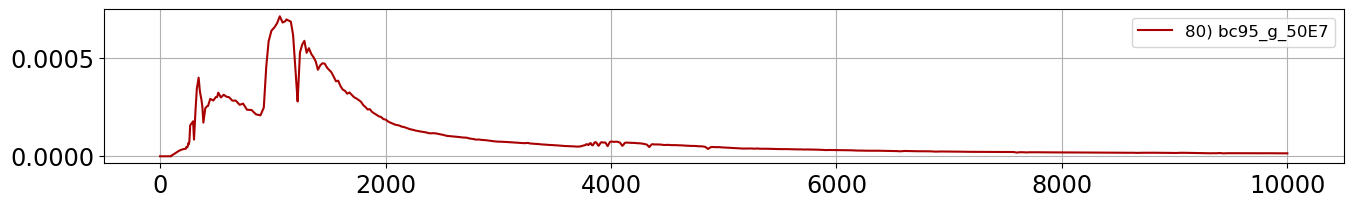

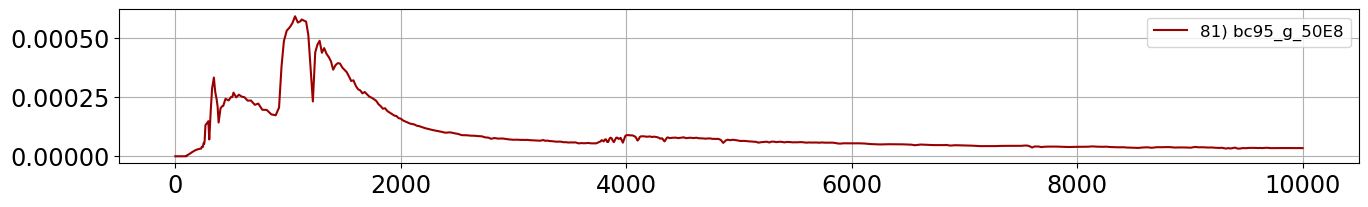

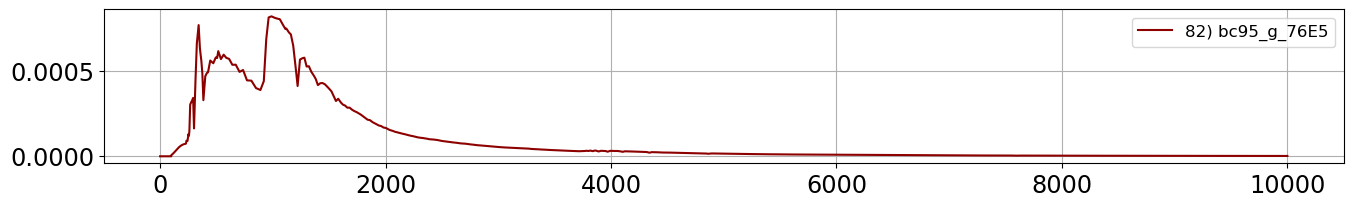

In [21]:
#plt.figure(figsize=(16,20))
for idx in range(NSED):
    plt.figure(figsize=(16,2))
    the_name=all_name[idx]
    the_label=f"{idx}) {the_name}"
    plt.plot(all_wl[idx],all_normspectra[idx], color=all_colors[idx],label=the_label)
    plt.legend(loc="upper right")
    plt.grid()
    #plt.axvline(4150,color="k")
    #plt.axvline(4250,color="k")
    #plt.ylim(-0.02,0.4)
    #plt.xlim(0.,20000.)
    plt.show()

# Format Tables fr PCA

### Wavelength

In [22]:
wls = np.stack(all_wl, axis=0).mean(axis=0)
NWL=len(wls)

### Flambdas

In [23]:
flambdas = np.stack(all_normspectra, axis=0 )

In [24]:
np.argwhere(np.isnan(flambdas))

array([], shape=(0, 2), dtype=int64)

In [25]:
flambdas_average = flambdas.mean(axis=0)

In [26]:
flambdas_std=flambdas.std(axis=0)

/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_81702/869007506.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:.0f}'.format(x) for x in current_values])


Text(0.5, 1.0, 'Flux average')

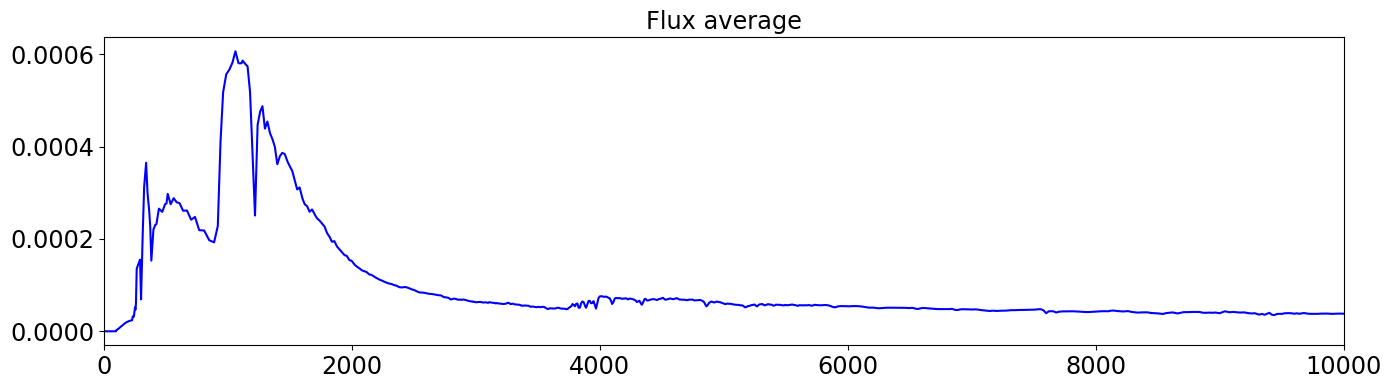

In [27]:
plt.figure(figsize=(16,4))
plt.plot(wls,flambdas_average,'b-')
plt.xlim(0.,10000.)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:.0f}'.format(x) for x in current_values])
plt.title("Flux average")

In [28]:
dflux=flambdas-flambdas_average
dfluxnorm = dflux/flambdas_std

/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_81702/892524575.py:2: RuntimeWarning: invalid value encountered in divide
  dfluxnorm = dflux/flambdas_std


Text(0.5, 1.0, 'flux residuals')

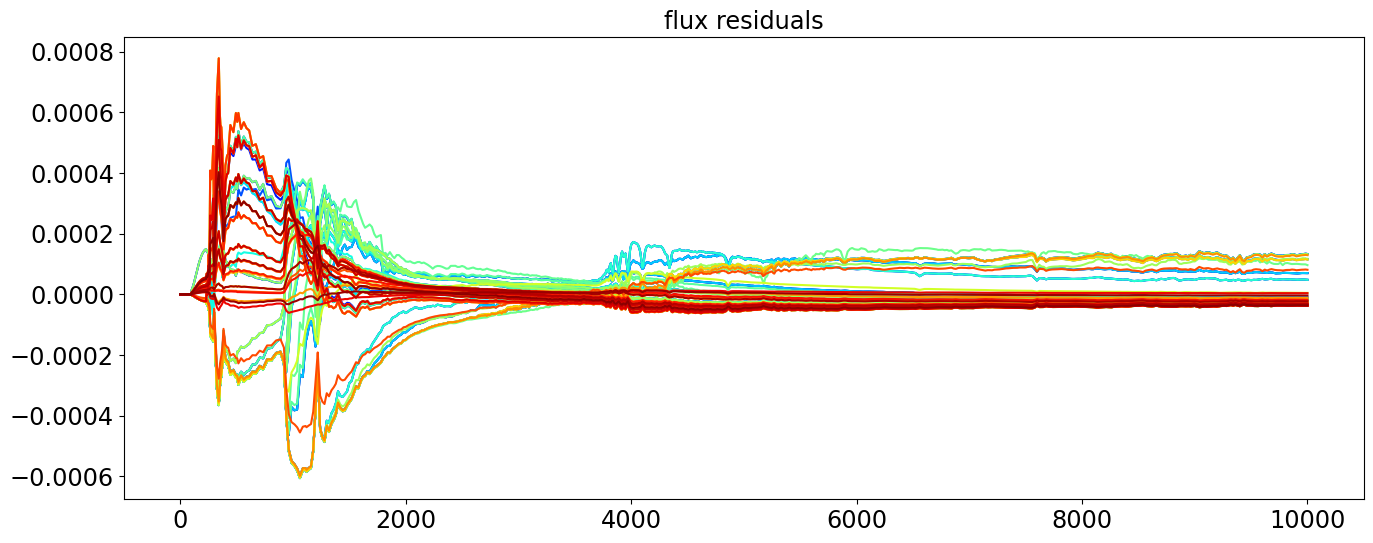

In [29]:
plt.figure(figsize=(16,6))
for idx in range(NSED):
    plt.plot(wls,dflux[idx], color=all_colors[idx])
    #plt.axvline(4150,color="k")
    #plt.axvline(4250,color="k")
    #plt.ylim(-0.02,0.4)
    #plt.xlim(0.,20000.)
plt.title("flux residuals")

Text(0.5, 1.0, 'normalised flux residuals')

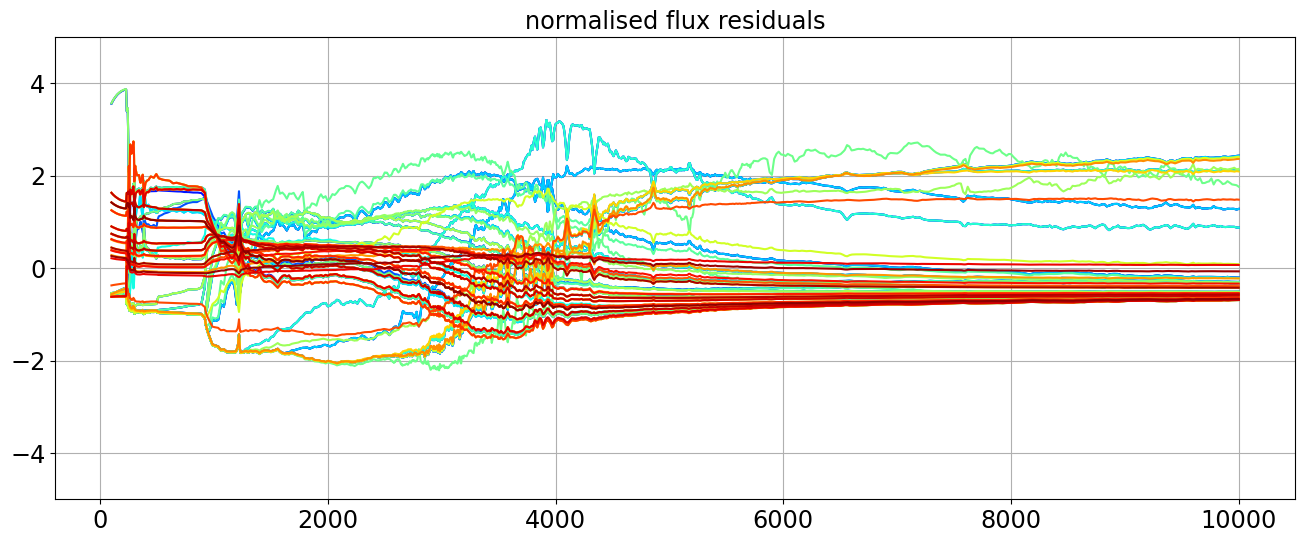

In [30]:
plt.figure(figsize=(16,6))
for idx in range(NSED):
    plt.plot(wls,dfluxnorm[idx], color=all_colors[idx])
    #plt.axvline(4150,color="k")
    #plt.axvline(4250,color="k")
    plt.ylim(-5,5)
    #plt.xlim(0.,20000.)
plt.grid()
plt.title("normalised flux residuals")

# Save data

In [31]:
hdr = fits.Header()

In [32]:
hdr["COMMENT"] = "Spectra of Brown"
hdr["DATAWLS"] = "data[0,1:]"
hdr["DATALLAV"] = "data[1,1:]"
hdr["DATALLST"] = "data[2,1:]"
hdr["DATAFL"] = "data[3:,1:]"
hdr["DATANUM"] = "data[3:,0]"

In [33]:
data_out = np.zeros((NSED+3,NWL+1))

In [34]:
data_out[0,1:] = wls
data_out[1,1:] = flambdas_average
data_out[2,1:] = flambdas_std
#data_out[3:,1:] = dfluxnorm
data_out[3:,1:] = flambdas
data_out[3:,0] = all_numbers

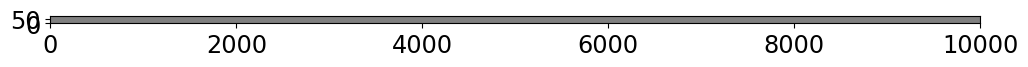

In [35]:
fig=plt.figure(figsize=(12,8))
ax=fig.add_subplot(1,1,1)
ax.set_aspect('equal')
ax.imshow(data_out[3:,1:],origin="lower",vmin=-4,vmax=4,cmap="gray")

In [36]:
data_out.shape
file_out = 'pca_BruzualCharlot_data.fits'

In [37]:
fits.writeto(file_out, data_out,hdr,overwrite=True)